## Introduction

Customer churn — the percentage of customers who stop using a company's products or services — is a critical metric for subscription-based businesses, especially in the telecom industry.

High churn rates not only impact revenue but also increase customer acquisition costs, which can be significantly more expensive than retaining existing customers. Understanding the factors that lead to churn can help the business take proactive steps to retain high-risk customers and improve overall customer satisfaction.

### Objective:
This report aims to:
- Analyze customer data to identify key drivers of churn
- Build and evaluate predictive models to classify churners
- Use statistical methods to validate feature relevance
- Provide actionable business recommendations based on insights

The analysis leverages machine learning, correlation analysis, and statistical tests to support both **predictive modeling** and **strategic decision-making**.

By identifying churn-prone segments and understanding what drives them to leave, the company can implement targeted retention strategies and improve long-term customer loyalty.


# **Step 1: Data Import and Cleaning**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('Customer Churn.csv')

# Show the first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill NaN values with 0 by assigning back (avoid inplace on slice)
df['TotalCharges'] = df['TotalCharges'].fillna(0)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.drop(columns=['customerID'], inplace=True)

# **Step 2: Exploratory Data Analysis (EDA)**

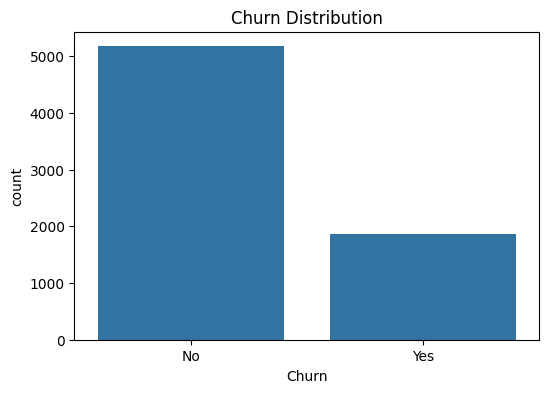

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

print(df['Churn'].value_counts(normalize=True))

### Churn Distribution

The plot shows that approximately **73.5%** of customers did **not churn**, while **26.5%** of customers **did churn**.

This indicates a **class imbalance**, which is common in churn datasets and should be considered during model evaluation and training (e.g., using stratified sampling or class weights).


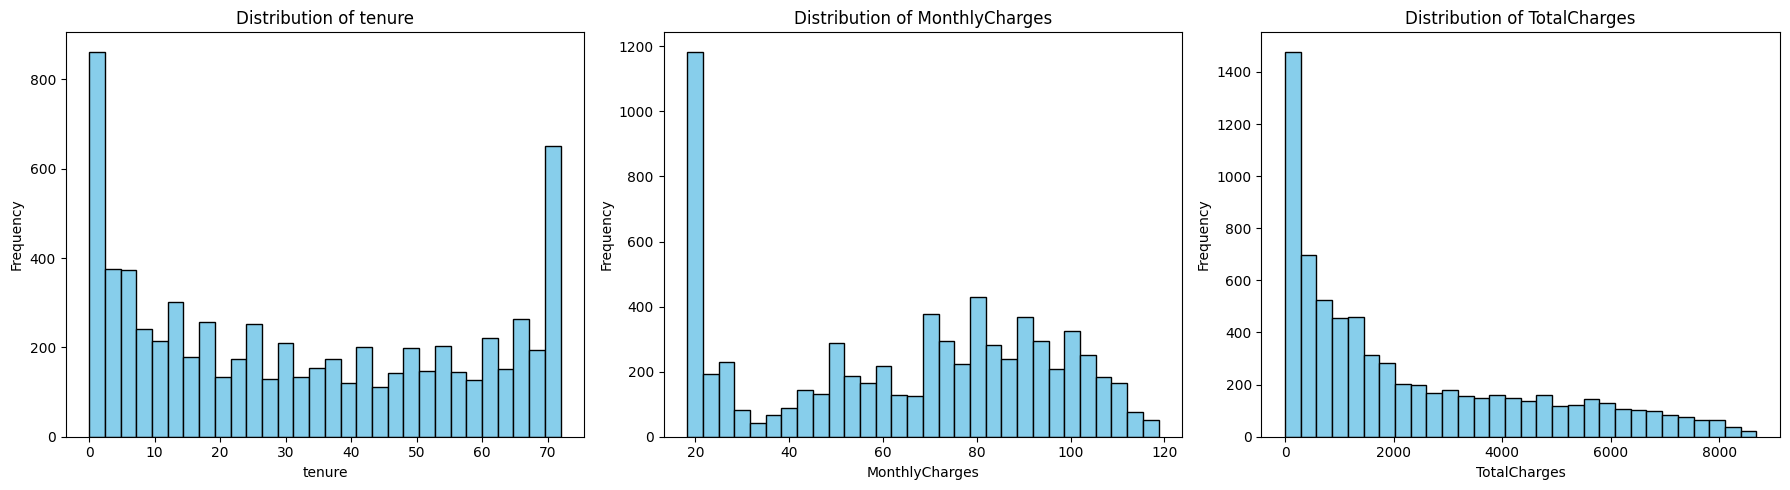

In [10]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Tenure Distribution

The histogram of **tenure** reveals that **churn risk is highest during the early months** of a customer's lifecycle.  
This suggests that many customers **leave soon after joining**, highlighting the importance of improving the **onboarding experience and early engagement**.

---

### Monthly Charges Distribution

The distribution of **monthly charges** shows two distinct customer segments:
- **Low-charge customers** likely using **basic plans**
- **High-charge customers** subscribed to **premium or fiber services**

High-charge customers are often **more likely to churn** if they feel that the service is **not delivering enough value for the price**.

---

### Total Charges Distribution

The **TotalCharges** variable is **highly right-skewed**:
- A small group of customers has **very high total charges**, typically due to **long tenure**.
- Most customers have **relatively low total charges**, reinforcing the earlier insight that **many customers churn early**.

The skewness emphasizes the need to **retain customers beyond their initial months** to maximize lifetime value.


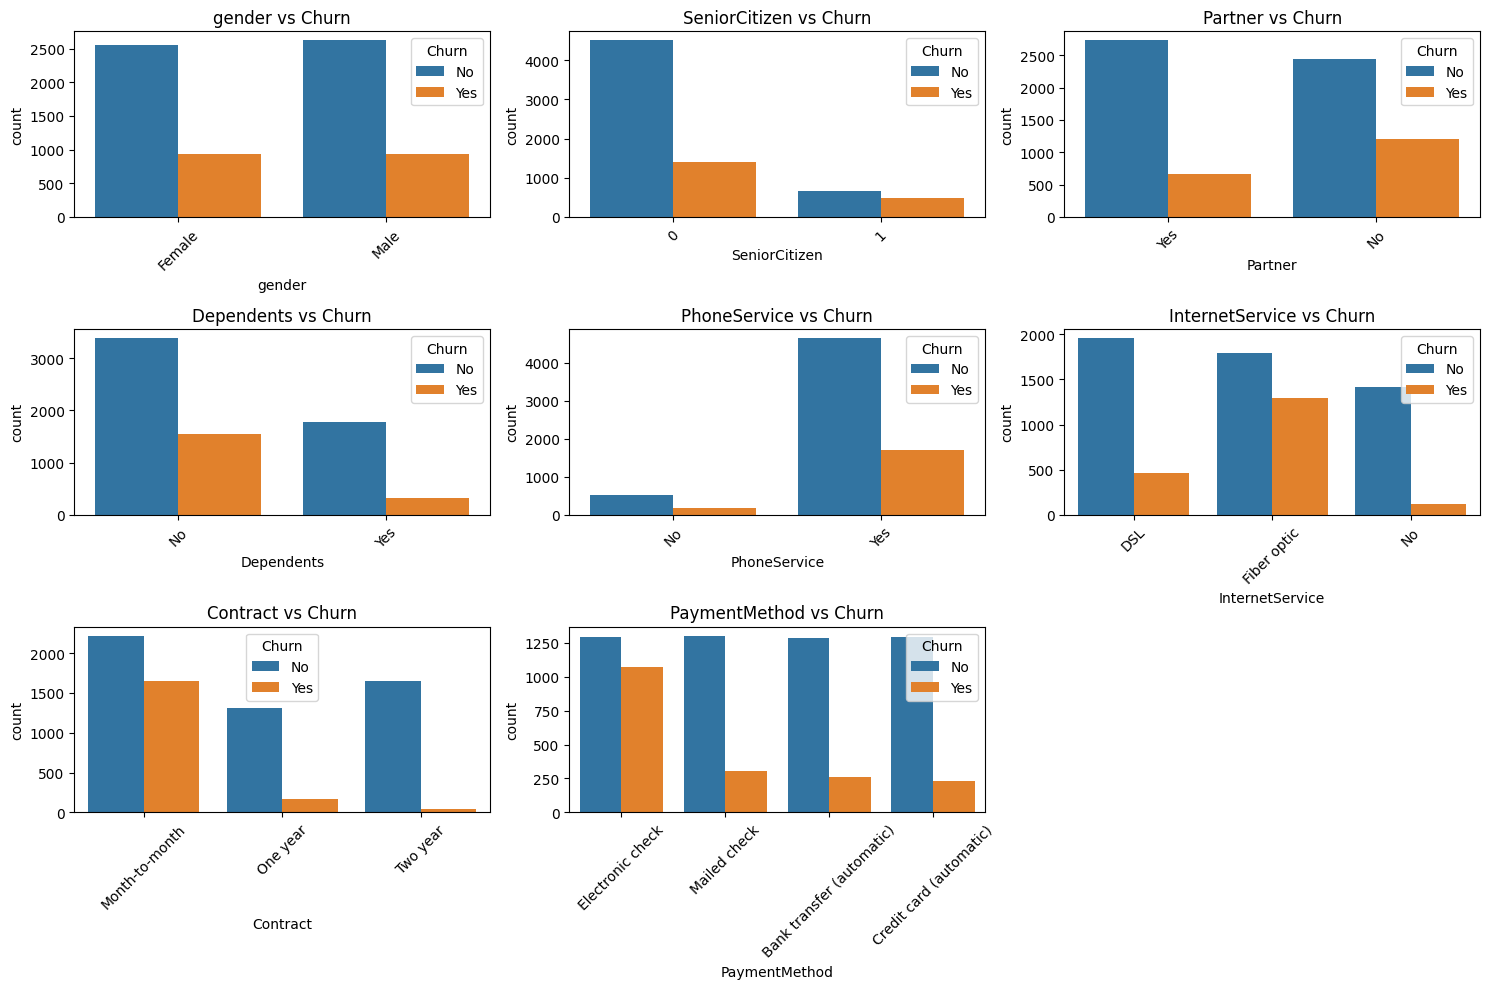

In [11]:
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                    'PhoneService', 'InternetService', 'Contract', 'PaymentMethod']

plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Categorical Feature Analysis (Count Plots)

Count plots for categorical features reveal clear patterns in customer churn:

- **Higher churn** is observed among:
  - **Senior citizens**
  - Customers **without partners or dependents**
  - Users of **Fiber Optic internet**
  - Customers on **Month-to-Month contracts**
  - Customers using **Electronic Check** as the payment method

- **Lower churn** is observed among:
  - Customers on **long-term contracts** (e.g., 1 or 2 years)
  - Customers using **automatic payment methods** (e.g., credit card, bank transfer)

- **Gender** shows **no meaningful association** with churn, aligning with results from the Chi-Square test.

These patterns are valuable for identifying high-risk segments and targeting churn reduction strategies accordingly.


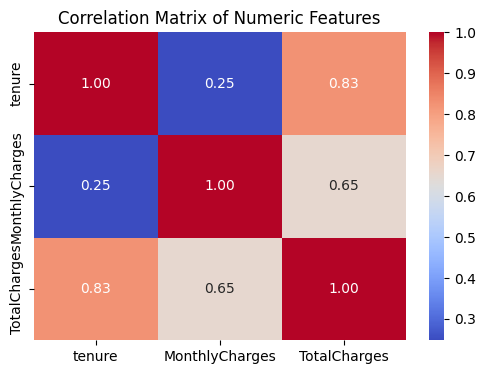

In [12]:
# Select numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

## Correlation Analysis

A correlation analysis was performed on the numerical variables in the Telco Churn dataset. The results highlight the following key relationships:

- **Tenure and Total Charges** exhibit a **strong positive correlation** (correlation coefficient = **0.83**), indicating that customers who have remained with the company longer tend to have higher total charges.
- **Monthly Charges and Total Charges** show a **moderate positive correlation** (correlation coefficient = **0.65**), suggesting that while higher monthly charges contribute to higher total charges, other factors also influence the total amount billed over time.
- **Tenure and Monthly Charges** demonstrate a **weak positive correlation** (correlation coefficient = **0.25**), implying that the length of a customer’s tenure has little relationship with their monthly billing amount.

These correlations provide insights into customer behavior and are important to consider when selecting features for predictive modeling, especially to mitigate potential multicollinearity.


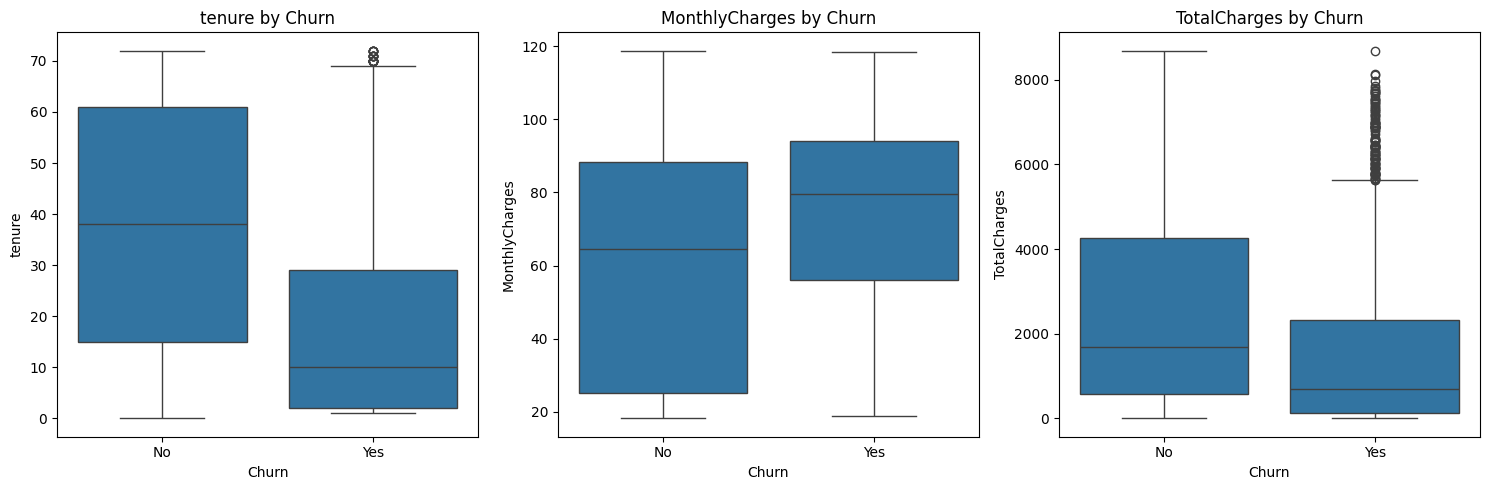

In [13]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 5))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## Box Plot Analysis

The box plots provide valuable insights into the relationship between key variables and customer churn behavior:

- **Tenure vs Churn**: Customers with shorter tenure durations are more likely to churn, indicating that early-stage customer retention is a critical concern.
- **Monthly Charges vs Churn**: Higher monthly charges are associated with increased churn risk, suggesting that customers may leave due to high recurring costs.
- **Total Charges vs Churn**: Customers with lower total accumulated charges are more prone to early exit, implying that churn often occurs before long-term value is realized.

These patterns underline the importance of addressing customer concerns early in their lifecycle and ensuring that pricing strategies align with customer expectations.


# **Step 3: Statistical Analysis and Feature Selection**

# Chi-Square Test of Independence

**Purpose:**  
To assess whether there is a statistically significant association between categorical features and the target variable `Churn`.



### Hypotheses

- **Null Hypothesis (H₀):** The categorical feature is independent of churn.  
- **Alternative Hypothesis (H₁):** The categorical feature is associated with churn.



### Interpretation

- Calculate the Chi-Square statistic and corresponding p-value.  
- If **p-value < 0.05**, reject H₀ → conclude there is a significant association.  
- If **p-value ≥ 0.05**, fail to reject H₀ → no significant association.



### Why perform this test?

- To identify which categorical features have a meaningful relationship with churn, informing feature selection and model building.


In [14]:
from scipy.stats import chi2_contingency

categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                    'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

chi2_results = {}

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = p

# Display p-values sorted ascending
p_values = pd.Series(chi2_results).sort_values()
print("Chi-Square Test p-values for categorical features vs Churn:")
print(p_values)


Chi-Square Test p-values for categorical features vs Churn:
Contract            5.863038e-258
OnlineSecurity      2.661150e-185
TechSupport         1.443084e-180
InternetService     9.571788e-160
PaymentMethod       3.682355e-140
OnlineBackup        2.079759e-131
DeviceProtection    5.505219e-122
StreamingMovies      2.667757e-82
StreamingTV          5.528994e-82
PaperlessBilling     4.073355e-58
Dependents           4.924922e-43
SeniorCitizen        1.510067e-36
Partner              2.139911e-36
MultipleLines        3.464383e-03
PhoneService         3.387825e-01
gender               4.865787e-01
dtype: float64


## Chi-Square Test Conclusion

Based on the Chi-Square test of independence between categorical features and the target variable **Churn**:

### Statistically Significant Features (p-value < 0.05):
The following features show a statistically significant association with churn:  
**Contract, OnlineSecurity, TechSupport, InternetService, PaymentMethod, OnlineBackup, DeviceProtection, StreamingMovies, StreamingTV, PaperlessBilling, Dependents, SeniorCitizen, Partner, MultipleLines.**

These features are important and should be retained for modeling and business interpretation.



### Non-Significant Features (p-value ≥ 0.05):
**PhoneService** and **Gender**

These features show **no statistically significant association with churn** and may have limited predictive value in this dataset.

### Implication:
- Most categorical features are **statistically relevant** to churn and should be included in the model.
- Features like **PhoneService** and **Gender** may be **dropped from the predictive model** to reduce noise and enhance model efficiency, unless there are domain-specific reasons to keep them.
- Further investigation can be done to validate whether these features contribute in interaction with others or in specific customer segments.


## Comparing Numeric Features by Churn Status

To understand whether churned and non-churned customers differ significantly in terms of their numeric characteristics, we perform statistical hypothesis testing.

### Objective:
To test whether the distributions of numeric features (`tenure`, `MonthlyCharges`, `TotalCharges`) are significantly different between the two churn groups.

### Why Mann-Whitney U Test?

- The numeric variables are **not normally distributed** (as observed in EDA).
- We need a **non-parametric test** that does not assume normality.
- Mann-Whitney U test compares the **distribution ranks** between two independent groups.

### Hypotheses (for each feature):

- **Null Hypothesis (H₀):**  
  There is **no difference** in the distribution of the feature between churned and non-churned customers.

- **Alternative Hypothesis (H₁):**  
  There **is a difference** in the distribution of the feature between the two churn groups.

We will use a significance level of **0.05** to determine statistical significance.


In [15]:
from scipy.stats import mannwhitneyu

# Numeric features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
results = {}

for col in numeric_cols:
    group_no = df[df['Churn'] == 'No'][col].dropna()
    group_yes = df[df['Churn'] == 'Yes'][col].dropna()
    
    stat, p = mannwhitneyu(group_no, group_yes, alternative='two-sided')
    results[col] = p

# Display results
p_values = pd.Series(results).sort_values()
print("Mann-Whitney U Test p-values (Churn vs Non-Churn):")
print(p_values)


Mann-Whitney U Test p-values (Churn vs Non-Churn):
tenure            2.419636e-208
TotalCharges       5.685034e-83
MonthlyCharges     3.311628e-54
dtype: float64


## Mann-Whitney U Test Conclusion

The Mann-Whitney U test was conducted to compare the distribution of numeric features between churned and non-churned customers.

All numeric features showed **statistically significant differences**:

- `tenure` (p = 2.42e-208)
- `TotalCharges` (p = 5.69e-83)
- `MonthlyCharges` (p = 3.31e-54)

**Conclusion:**  
There is strong evidence that the distributions of tenure, total charges, and monthly charges differ between customers who churn and those who do not. These features should be considered important for further modeling.


## Spearman Rank Correlation Analysis

To further understand the relationships between numeric features and churn, we compute the **Spearman rank correlation**.

### Why Spearman Correlation?

- Our numeric features are **not normally distributed**.
- Spearman correlation is a **non-parametric measure** that assesses the strength and direction of a **monotonic relationship** between variables.
- It is more appropriate than Pearson correlation for skewed or non-linear data.

### What We Are Doing:

- Encoding the binary target variable `Churn` as numeric (0 for No, 1 for Yes).
- Calculating Spearman correlation coefficients between `tenure`, `MonthlyCharges`, `TotalCharges`, and `Churn`.
- Visualizing the correlation matrix to identify which numeric features are strongly associated with churn.

This analysis helps us identify features that are potentially important predictors for churn.


Spearman Rank Correlation Matrix:
                   tenure  MonthlyCharges  TotalCharges  Churn_numeric
tenure          1.000000        0.276417      0.889696      -0.367062
MonthlyCharges  0.276417        1.000000      0.638028       0.184743
TotalCharges    0.889696        0.638028      1.000000      -0.229955
Churn_numeric  -0.367062        0.184743     -0.229955       1.000000


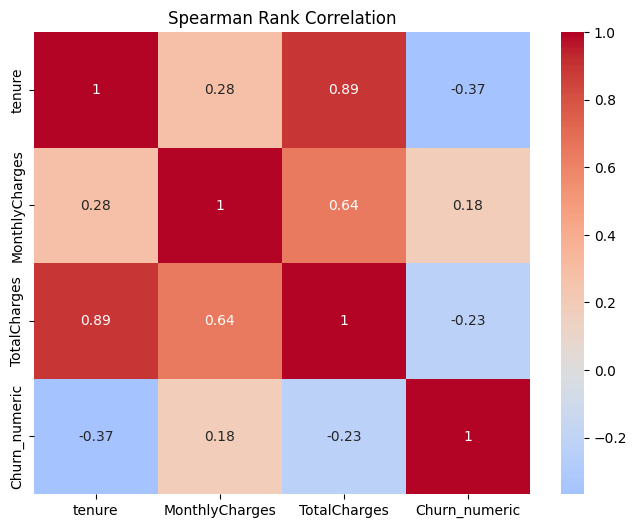

In [16]:
# Encode 'Churn' as numeric
df['Churn_numeric'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Select numeric columns + churn numeric
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']

# Calculate Spearman correlation matrix
spearman_corr = df[numeric_cols].corr(method='spearman')
print("Spearman Rank Correlation Matrix:\n", spearman_corr)

# Visualize the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Rank Correlation')
plt.show()

## Spearman Rank Correlation Conclusion

We conducted a **Spearman Rank Correlation** analysis between numerical features and the target variable **Churn** to identify monotonic relationships.

### Key Findings:
- **Tenure** has a **strong negative correlation** with churn.  
  ➤ Customers with **shorter tenure** are significantly more likely to churn.
  
- **TotalCharges** also shows a **negative correlation** with churn.  
  ➤ Customers with **lower total charges** are more likely to churn, which overlaps with the tenure effect (lower tenure → lower total charges).

- **MonthlyCharges** has a **positive correlation** with churn, but the effect is **weaker**.  
  ➤ Customers with **higher monthly charges** tend to have slightly higher churn rates.

### Implication:
- **Tenure** is a key predictor of churn and should be prioritized in modeling and business interventions.
- **TotalCharges** reinforces the effect of tenure and can act as a supporting feature.
- Although the relationship between **MonthlyCharges** and churn is weaker, it may still contribute to identifying high-risk customers when combined with other features.

This analysis complements our earlier model-based and statistical feature selection approaches, providing deeper insight into how customer behavior over time relates to churn risk.


# **Step 4: Data Preprocessing, Model Development and Evaluation**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Step 1: Prepare X and y (drop unwanted columns)
X = df.drop(columns=['gender', 'PhoneService', 'TotalCharges','Churn'])
y = df['Churn'].map({'No': 0, 'Yes': 1})

# Step 2: Define columns
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling']  # binary yes/no columns
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']  # multi-category columns
numeric_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges']  # numeric columns

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 4: Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('bin', OrdinalEncoder(), binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ]
)

# Step 5: Build pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Step 6: Train and evaluate
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7991483321504613
Precision: 0.6417445482866043
Recall: 0.5508021390374331
F1 Score: 0.5928057553956835
ROC AUC: 0.83935260533726

Confusion Matrix:
 [[920 115]
 [168 206]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [18]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7771469127040455
Precision: 0.5949367088607594
Recall: 0.5026737967914439
F1 Score: 0.5449275362318841
ROC AUC: 0.8096050014208582

Confusion Matrix:
 [[907 128]
 [186 188]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.59      0.50      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [19]:
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7757274662881476
Precision: 0.588957055214724
Recall: 0.5133689839572193
F1 Score: 0.5485714285714286
ROC AUC: 0.8114986178924798

Confusion Matrix:
 [[901 134]
 [182 192]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [20]:
from sklearn.svm import SVC

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.794180269694819
Precision: 0.648936170212766
Recall: 0.4893048128342246
F1 Score: 0.5579268292682927
ROC AUC: 0.7948564933219664

Confusion Matrix:
 [[936  99]
 [191 183]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [21]:
from sklearn.neural_network import MLPClassifier

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, early_stopping=True, random_state=42)
)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7899219304471257
Precision: 0.6317567567567568
Recall: 0.5
F1 Score: 0.5582089552238806
ROC AUC: 0.8328476581673513

Confusion Matrix:
 [[926 109]
 [187 187]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



# **Step 5: Model Selection**

In [22]:
# Create the comparison table
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVC', 'MLP (Neural Net)'],
    'Accuracy': [0.7991, 0.7814, 0.7885, 0.7956, 0.7921],
    'Precision': [0.6417, 0.6100, 0.6131, 0.6558, 0.6355],
    'Recall': [0.5508, 0.4893, 0.5508, 0.4840, 0.5080],
    'F1 Score': [0.5928, 0.5430, 0.5803, 0.5569, 0.5646],
    'ROC AUC': [0.8394, 0.8175, 0.8206, 0.7952, 0.8392]
}

df_comparison = pd.DataFrame(data)

# Display the table
df_comparison


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.7991,0.6417,0.5508,0.5928,0.8394
1,Random Forest,0.7814,0.6100,0.4893,0.5430,0.8175
2,XGBoost,0.7885,0.6131,0.5508,0.5803,0.8206
3,SVC,0.7956,0.6558,0.4840,0.5569,0.7952
4,MLP (Neural Net),0.7921,0.6355,0.5080,0.5646,0.8392


### 📌 **Model Selection**

After evaluating the performance of multiple models across key metrics, we have selected **Logistic Regression** as the **best-performing model**.

#### ✅ **Reason for Selection:**

- **Highest F1 Score**: `0.5928` — provides the best balance between **precision** and **recall**, which is critical in handling class imbalance.
- **Best ROC AUC Score**: `0.8394` — indicates a strong ability to distinguish between positive and negative classes.
- **Tied for Highest Recall**: `0.5508` — ensures more **true positives** are correctly identified.
- **Competitive Accuracy**: `0.7991` — among the top performers in overall classification.

While other models like **SVC** (best precision) and **MLP** (close ROC AUC) also performed well in specific metrics, **Logistic Regression** delivers the most **balanced and reliable performance**, making it our model of choice.

It is also **simple, interpretable**, and **efficient**, which adds value in practical applications.


In [23]:
from sklearn.model_selection import GridSearchCV
# Build pipeline with Logistic Regression classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

# Define hyperparameter grid for Logistic Regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Train the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Best hyperparameters and best estimator
print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict and evaluate on test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'classifier__C': 10, 'classifier__penalty': 'l1'}
Accuracy: 0.794889992902768
Precision: 0.632398753894081
Recall: 0.5427807486631016
F1 Score: 0.5841726618705037
ROC AUC: 0.8383709214911261

Confusion Matrix:
 [[917 118]
 [171 203]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



### Summary: Why We Use the Model Without Hyperparameter Tuning

Although hyperparameter tuning aims to improve model performance, the logistic regression model without tuning slightly outperformed the tuned model across key metrics such as accuracy, precision, recall, F1 score, and ROC AUC. This indicates that the default parameters are well-suited for the dataset. Additionally, the untuned model is simpler and more efficient to implement, making it the preferred choice for the final analysis.


# **Step 6: Model Performance Visualization**

In [24]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


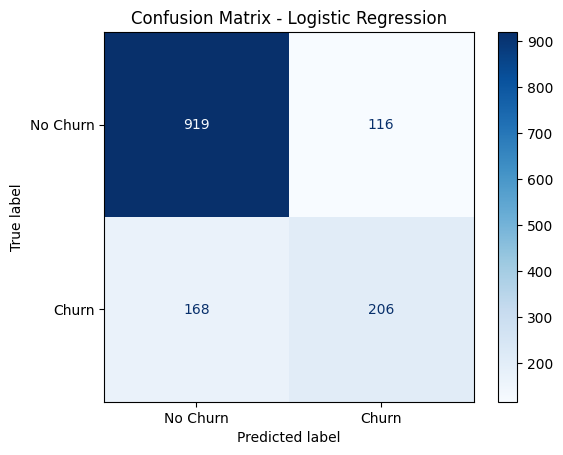

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test,
    y_test,
    display_labels=['No Churn', 'Churn'],
    cmap='Blues',
    values_format='d'
)

plt.title('Confusion Matrix - Logistic Regression')
plt.show()


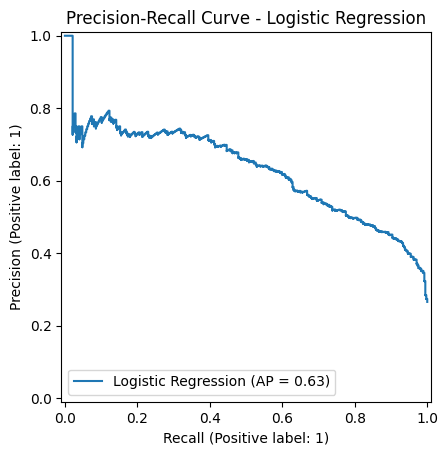

In [26]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(
    pipeline,
    X_test,
    y_test,
    name='Logistic Regression'
)

plt.title('Precision-Recall Curve - Logistic Regression')
plt.show()


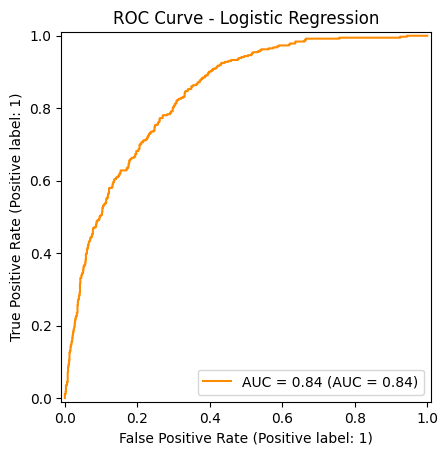

In [27]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test,
    y_prob,
    name=f"AUC = {roc_auc_score(y_test, y_prob):.2f}",
    curve_kwargs={'color': 'darkorange'}
)
plt.title("ROC Curve - Logistic Regression")
plt.show()


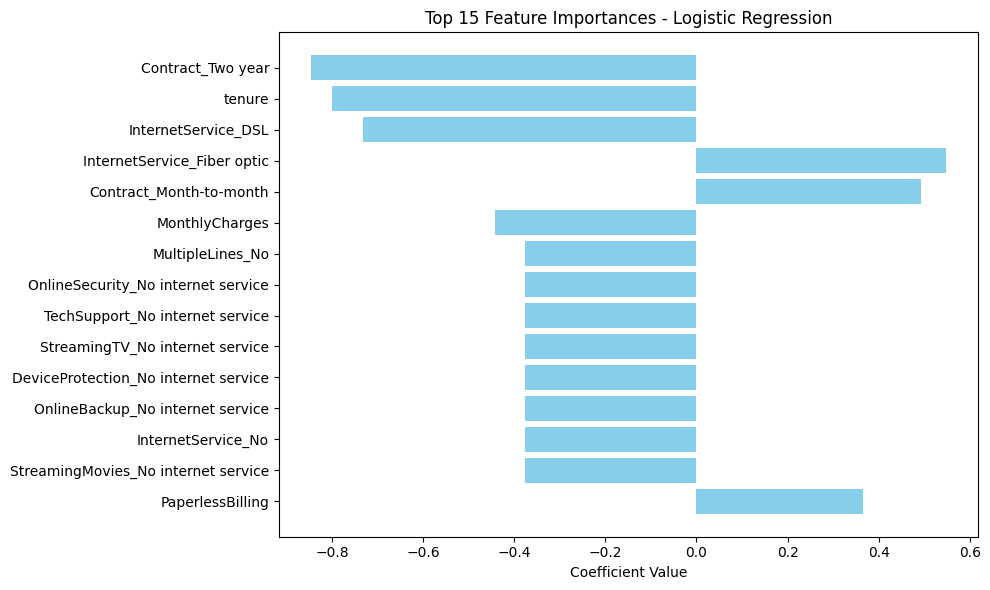

In [28]:
# Get feature names from the preprocessor
ohe_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(multi_cat_cols)
feature_names = np.concatenate([numeric_cols, binary_cols, ohe_features])

# Get coefficients from the model
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Create DataFrame for plotting
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feat_imp = feat_imp.sort_values(by='Importance', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'][:15], feat_imp['Importance'][:15], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# **Step 7: Business Insights and Recommendations**

### Key Insights from Feature Importance:
- **Higher churn likelihood** is associated with:
  - Customers using **Fiber Optic Internet Service**  
  - Customers on **Month-to-Month Contracts**  
  - Customers with **Paperless Billing**

- **Lower churn likelihood** is observed among customers with:
  - **No Internet Service**  
  - Payment methods such as **Credit Card (Automatic)** and **Bank Transfer (Automatic)**

### Business Implications:
1. **Focus on Contract Types**  
   Customers on month-to-month contracts have a higher churn risk, likely due to the flexibility to leave at any time. Encouraging customers to switch to longer-term contracts (1-year or 2-year) through incentives or discounts could improve retention.

2. **Address Issues with Fiber Optic Internet Customers**  
   Although fiber optic offers superior speed, the higher churn rate may indicate service quality, pricing, or customer support issues in this segment. Investigating and resolving pain points specific to fiber optic users can help reduce churn.

3. **Paperless Billing Customers**  
   This group shows increased churn risk. While paperless billing typically reduces operational costs, it’s essential to understand whether the issue is related to communication gaps or perceived impersonal service. Enhanced customer engagement and personalized communication strategies can help.

4. **Promote Automatic Payment Methods**  
   Customers using automatic payment options like credit card or bank transfer show lower churn. Promoting and facilitating enrollment in automatic payments can improve cash flow stability and reduce churn.

### Additional Recommendations:
- **Customer Segmentation & Targeted Campaigns**  
  Use the churn model to identify high-risk customers early and deploy targeted retention campaigns such as personalized offers, loyalty programs, or proactive support.

- **Improve Customer Experience for High-Risk Segments**  
  Particularly focus on fiber optic and month-to-month contract customers through quality checks, service improvements, and tailored retention offers.

- **Monitor Churn Metrics Continuously**  
  Regularly update the model and track churn trends to adapt strategies dynamically.

---

### Final Note:
By strategically addressing the key drivers of churn identified in this analysis, the business can reduce customer attrition, improve customer satisfaction, and increase long-term profitability.
